In [1]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

c:\Users\abdullah.jirjees\Anaconda3\envs\gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\abdullah.jirjees\Anaconda3\envs\gpu\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\abdullah.jirjees\Anaconda3\envs\gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Read depth image:
depth_image = iio.imread('data/depth.png')

# print properties:
print(f"Image resolution: {depth_image.shape}")
print(f"Data type: {depth_image.dtype}")
print(f"Min value: {np.min(depth_image)}")
print(f"Max value: {np.max(depth_image)}")

Image resolution: (480, 640)
Data type: int32
Min value: 0
Max value: 2980


In [5]:

depth_grayscale = np.array(256 * depth_image / 0x0fff,
                            dtype=np.uint8)
iio.imwrite('output/grayscale.png', depth_grayscale)

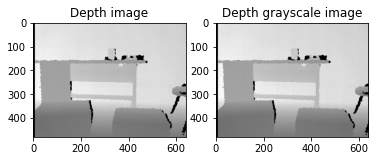

In [7]:
# Display depth and grayscale image:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(depth_image, cmap="gray")
axs[0].set_title('Depth image')
axs[1].imshow(depth_grayscale, cmap="gray")
axs[1].set_title('Depth grayscale image')
plt.show()

In [8]:
# Depth camera parameters:
FX_DEPTH = 5.8262448167737955e+02
FY_DEPTH = 5.8269103270988637e+02
CX_DEPTH = 3.1304475870804731e+02
CY_DEPTH = 2.3844389626620386e+02

In [9]:
# compute point cloud:
pcd = []
height, width = depth_image.shape
for i in range(height):
   for j in range(width):
       z = depth_image[i][j]
       x = (j - CX_DEPTH) * z / FX_DEPTH
       y = (i - CY_DEPTH) * z / FY_DEPTH
       pcd.append([x, y, z])

In [10]:

pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])

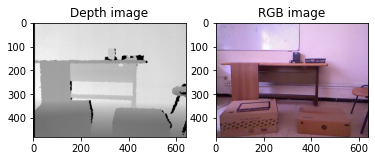

In [12]:
# Read the rgb image:
rgb_image = iio.imread('data/rgb.jpg')

# Display depth and grayscale image:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(depth_image, cmap="gray")
axs[0].set_title('Depth image')
axs[1].imshow(rgb_image)
axs[1].set_title('RGB image')
plt.show()

In [13]:
# Rotation matrix:
R = -np.array([[9.9997798940829263e-01, 5.0518419386157446e-03, 4.3011152014118693e-03],
                   [-5.0359919480810989e-03, 9.9998051861143999e-01, -3.6879781309514218e-03],
                   [- 4.3196624923060242e-03, 3.6662365748484798e-03, 9.9998394948385538e-01]])
# Translation vector:
T = np.array([2.5031875059141302e-02, -2.9342312935846411e-04, 6.6238747008330102e-04])

In [14]:
# RGB camera intrinsic Parameters:
FX_RGB = 5.1885790117450188e+02
FY_RGB = 5.1946961112127485e+02
CX_RGB = 3.2558244941119034e+0
CY_RGB = 2.5373616633400465e+02

In [16]:
"""
  Convert the point from depth sensor 3D coordinate system
  to rgb camera coordinate system:
"""
[x_RGB, y_RGB, z_RGB] = np.linalg.inv(R).dot([x, y, z]) - np.linalg.inv(R).dot(T)

In [17]:
j_rgb = int((x_RGB * FX_RGB) / z_RGB + CX_RGB + width / 2)
i_rgb = int((y_RGB * FY_RGB) / z_RGB + CY_RGB)

In [18]:
colors = []
pcd = []
for i in range(height):
    for j in range(width):
        """
            Convert the pixel from depth coordinate system
            to depth sensor 3D coordinate system
        """
        z = depth_image[i][j]
        x = (j - CX_DEPTH) * z / FX_DEPTH
        y = (i - CY_DEPTH) * z / FY_DEPTH

        """
            Convert the point from depth sensor 3D coordinate system
            to rgb camera coordinate system:
        """
        [x_RGB, y_RGB, z_RGB] = np.linalg.inv(R).dot([x, y, z]) - np.linalg.inv(R).dot(T)

        """
            Convert from rgb camera coordinates system
            to rgb image coordinates system:
        """
        j_rgb = int((x_RGB * FX_RGB) / z_RGB + CX_RGB + width / 2)
        i_rgb = int((y_RGB * FY_RGB) / z_RGB + CY_RGB)

        # Add point to point cloud:
        pcd.append([x, y, z])

        # Add the color of the pixel if it exists:
        if 0 <= j_rgb < width and 0 <= i_rgb < height:
            colors.append(rgb_image[i_rgb][j_rgb] / 255)
        else:
            colors.append([0., 0., 0.])
            
# Convert to Open3D.PointCLoud:
pcd_o3d = o3d.geometry.PointCloud()  # create a point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])